# Vertex Tabular Binary Classification with .CustomJob()

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jchavezar/vertex-ai-samples/blob/main/vertex-custom-ml/tensorflow/custom_jobs/container-xai-tabclass.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
</table>

This sample is about how to train a model usign different aiplatform components:
- container image store
- vertex training (custom job)
- model store
- online predictions

<img src="../../../images/python-distribution-package-tabclass.png"/>

In [ ]:
! pip3 install --upgrade google-cloud-aiplatform -q google-cloud-bigquery db-dtypes

## Colab only: Uncomment the following cell to restart the kernel.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

## Set Constants

In [ ]:
PROJECT_ID = 'jchavezar-demo' # @param {type:"string"}
REGION = 'us-central1' # @param {type:"string"}
DATASETS_URI = 'gs://vtx-datasets-public/ecommerce' # @param {type:"string"}
MODEL_URI = 'gs://vtx-models/ecommerce/03tb' # @param {type:"string"}
STAGING_URI = 'gs://vtx-staging/ecommerce/03tb' # @param {type:"string"}
TRAIN_IMAGE_URI = 'us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-9:latest' # @param {type:"string"}
PREDICTION_IMAGE_URI = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-9:latest' # @param {type:"string"}
SERIES = '03tb' # @param {type:"string"}
EXPERIMENT_NAME = 'ecommerce-exp' # @param {type:"string"}

In [ ]:
## Set the Project
! gcloud config set project $PROJECT_ID

## Create Folder Structure

```
tmp
└─── source
     |  setup.py
     |
     └─── trainer
          |  __init__.py
          |  train.py
          |

```

In [ ]:
!rm -fr source
!mkdir -p source/trainer

## Create Python Source Distribution Files 

In [17]:
%%writefile source/trainer/train.py

import os
import time
import warnings
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
warnings.filterwarnings('ignore')

################################### ARGUMENTS #######################################


parser = argparse.ArgumentParser()
parser.add_argument(
    '--train_data_uri', 
    help = 'dataset to train',
    type = str
)
parser.add_argument(
    '--val_data_uri', 
    help = 'val to train',
    type = str
)
parser.add_argument(
    '--test_data_uri', 
    help = 'test to train',
    type = str
)
args = parser.parse_args()

train_df = pd.read_csv(args.train_data_uri)
val_df = pd.read_csv(args.val_data_uri)
test_df = pd.read_csv(args.test_data_uri)
print('test')

################################### PREPROCESSING #######################################

## Convert pandas dataframe to tensor data (from GCS to TF.data.Data)
init_start = time.process_time()
def df_to_dataset(dataframe, shuffle=None):
    df = dataframe.copy()
    labels = df.pop('will_buy_on_return_visit')
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
      
## Normalization / Standarization
def get_normalization_layer(name, dataset):
    start = time.process_time()
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    print(f'Normalization time for {name}: {time.process_time() - start}')
    return normalizer

# Performs feature-wise categorical encoding of inputs features
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    start = time.process_time()
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    print(f'Encoding time for {name}: {time.process_time() - start}')
    return lambda feature: encoder(index(feature))

batch_size = 256
train_ds = df_to_dataset(train_df)
val_ds = df_to_dataset(val_df)
test_ds = df_to_dataset(test_df)

## Identify Numerical and Categorical columns:
num_columns = ['latest_ecommerce_progress', 'time_on_site', 'pageviews']
cat_columns = ['source', 'medium', 'channel_grouping', 'device_category', 'country']
num_cat_columns = 'bounces'

all_inputs = []
encoded_features = []

# Numerical Features.
for header in num_columns:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)
    
# Categorical Features.
for header in cat_columns:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                 dataset=train_ds,
                                                 dtype='string',
                                                 max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

## Integer values into integer indices.
bounces_col = tf.keras.Input(shape=(1,), name=num_cat_columns, dtype='int64')

encoding_layer = get_category_encoding_layer(name=num_cat_columns,
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(bounces_col)
all_inputs.append(bounces_col)
encoded_features.append(encoded_age_col)

print(f'Total preprocessing time: {time.process_time() - init_start}')

#########################################################################################


################################### CREATE, COMPILE AND TRAIN MODEL #####################

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print('compile pass')
################################## SETUP TENSORBOARD LOGS AND TRAIN #####################

print(os.environ['AIP_TENSORBOARD_LOG_DIR'])
print('---------------------')
print(os.environ['AIP_MODEL_DIR'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.environ['AIP_TENSORBOARD_LOG_DIR'], update_freq='batch', histogram_freq=0)
model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[tensorboard_callback])
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

################################### SAVE MODEL ##########################################

model.save(os.environ['AIP_MODEL_DIR'])

Overwriting source/trainer/train.py


In [18]:
%%writefile source/setup.py
from setuptools import setup
from setuptools import find_packages

setup(
    name = 'trainer',
    version = '0.1',
    packages = find_packages(),
    include_package_data = True,
    description='Training Package'
)

Overwriting source/setup.py


In [19]:
!touch source/trainer/__init__.py

In [20]:
!rm -f source.tar source.tar.gz
!tar cvf source.tar source
!gzip source.tar
!gsutil cp source.tar.gz {MODEL_URI}/packages/source.tar.gz

source/
source/setup.py
source/trainer/
source/trainer/__init__.py
source/trainer/train.py
Copying file://source.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  2.0 KiB/  2.0 KiB]                                                
Operation completed over 1 objects/2.0 KiB.                                      


## Create Tensorboard

In [ ]:
from google.cloud import aiplatform as aip

tb = aip.Tensorboard.list(filter=f"labels.series={SERIES}")
if tb:
    tb = tb[0]
else: 
    tb = aip.Tensorboard.create(display_name=SERIES, labels={'series' : f'{SERIES}'})

## Create Vertex Training from Code [CustomJob]

In [15]:
from google.cloud import aiplatform as aip

In [ ]:
aip.init(
    #experiment=EXPERIMENT_NAME,
    #experiment_tensorboard=tb.resource_name,
    project=PROJECT_ID,
    location=REGION)


worker_pool_specs = [
    {
        'machine_spec' : {
            'machine_type': 'n1-standard-4'
        },
        'replica_count': 1,
        'python_package_spec': {
            'executor_image_uri': TRAIN_IMAGE_URI,
            'package_uris': [MODEL_URI+'/packages/source.tar.gz'],
            'python_module': 'trainer.train',
            'args': [
                '--train_data_uri='+f'{DATASETS_URI}/train.csv',
                '--val_data_uri='+f'{DATASETS_URI}/val.csv',
                '--test_data_uri='+f'{DATASETS_URI}/test.csv',
            ]
        }
    }
]

job = aip.CustomJob(
    display_name = 'ecommerce_tf',
    worker_pool_specs = worker_pool_specs,
    base_output_dir = MODEL_URI,
    staging_bucket = STAGING_URI
)

model = job.run(
    service_account = 'vtx-pipe@jchavezar-demo.iam.gserviceaccount.com',
    #tensorboard = tb.resource_name
)

## Get Model Information from Tensorflow Graph

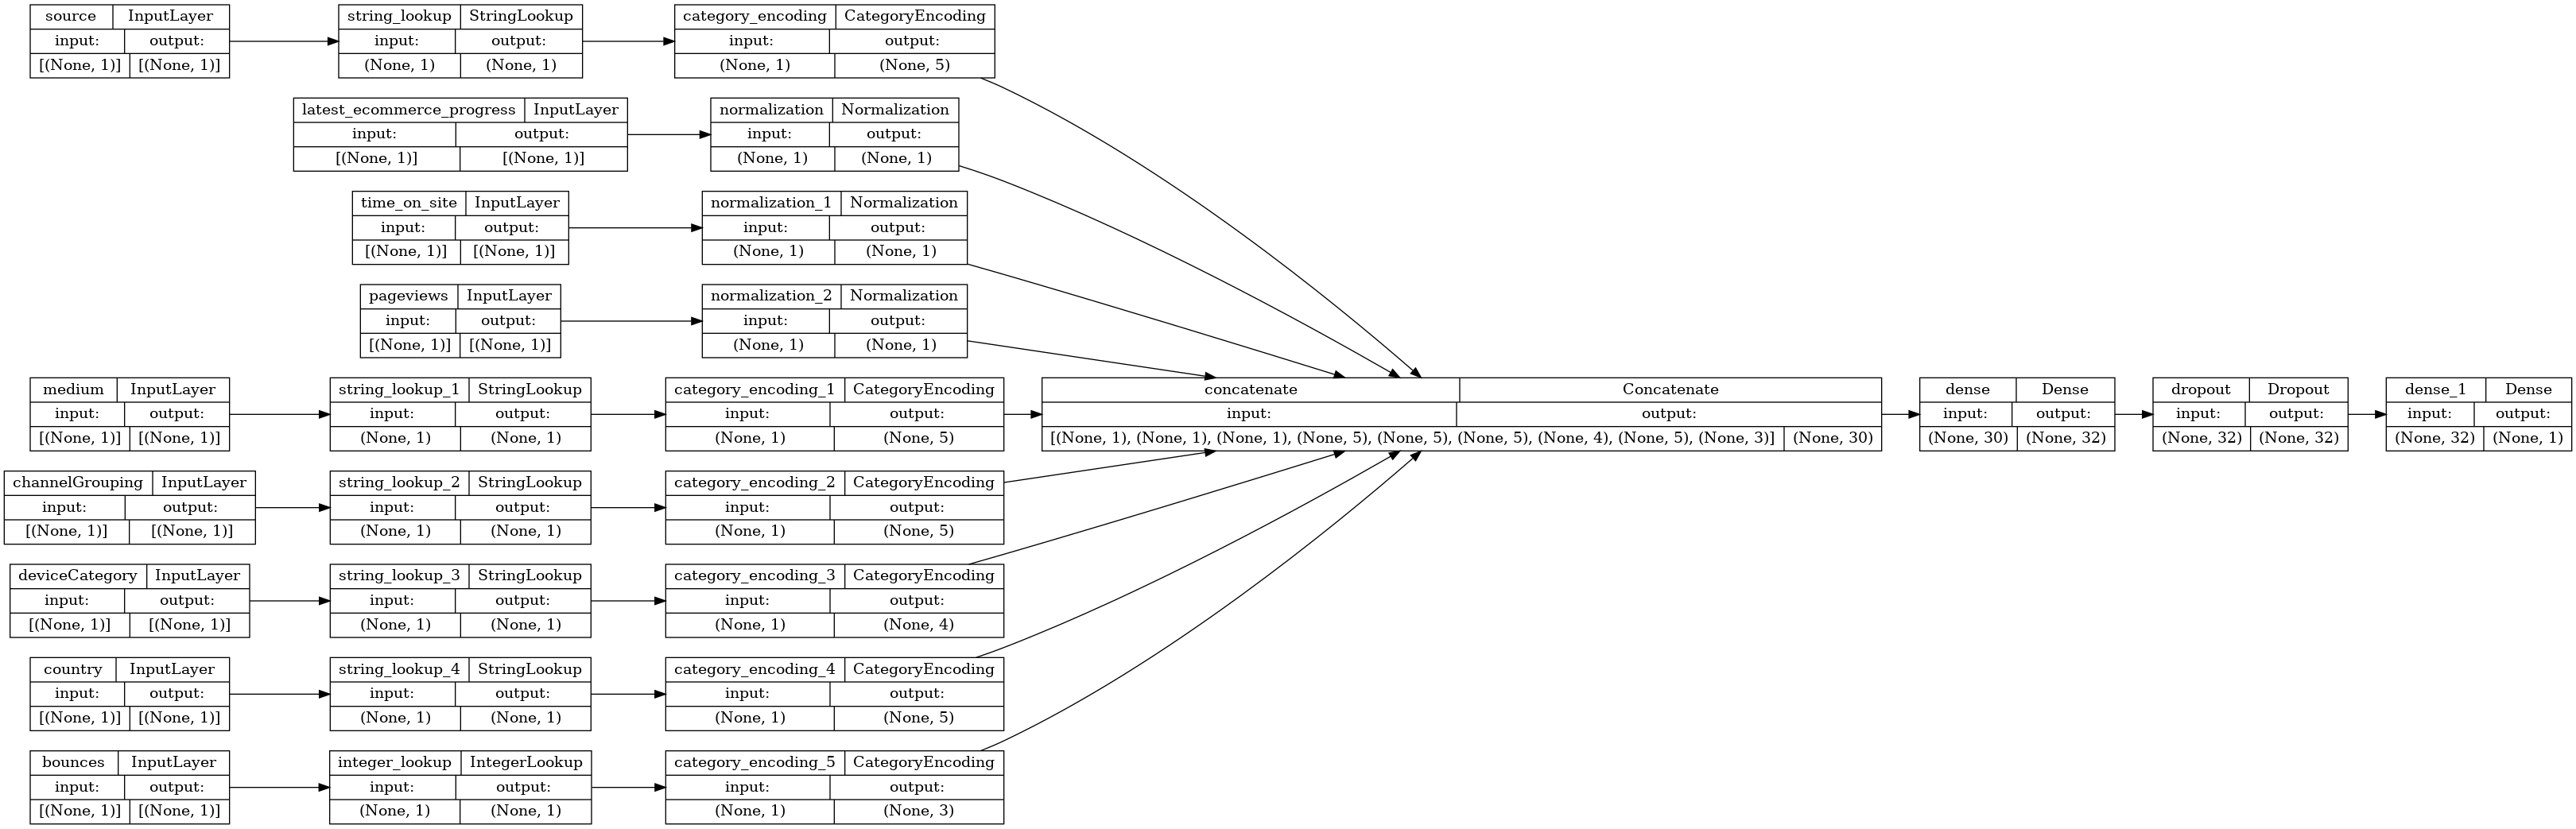

In [13]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

loaded_model = tf.keras.models.load_model(f"{MODEL_URI}/model")
tf.keras.utils.plot_model(loaded_model, show_shapes=True, rankdir="LR")

## Build Explainable AI Metadata from Graph

In [ ]:
infer = loaded_model.signatures['serving_default']
print(infer.inputs)
print()
print(infer.structured_outputs)

In [ ]:
EXPLANATION_METADATA = {
    "outputs": {
        "logit": { 
            "output_tensor_name": "dense_1"
        }
    },
    "inputs": { 
        "latest_ecommerce_progress": {},
        "bounces": {},
        "time_on_site": {},
        "pageviews": {},
        "source": {},
        "medium": {},
        "channelGrouping": {},
        "deviceCategory": {},
        "country": {},
    }
}
EXPLANATION_PARAMS = {"sampled_shapley_attribution": {"path_count": 5}}

## Upload Model

In [14]:
model = aip.Model.upload(
    display_name = 'ecommerce_tf',
    serving_container_image_uri = PREDICTION_IMAGE_URI,
    artifact_uri = f'{MODEL_URI}/model',
    explanation_parameters=EXPLANATION_PARAMS,
    explanation_metadata=EXPLANATION_METADATA,
)

Creating Model
Create Model backing LRO: projects/569083142710/locations/us-central1/models/3269116350215225344/operations/208310518060941312
Model created. Resource name: projects/569083142710/locations/us-central1/models/3269116350215225344@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/3269116350215225344@1')


## Deploy Model On Endpoint

In [15]:
endpoint = model.deploy(
    deployed_model_display_name = 'ecommerce_tf_ep_dep',
    traffic_percentage = 100,
    machine_type = 'n1-standard-4',
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_metadata=EXPLANATION_METADATA,
    explanation_parameters=EXPLANATION_PARAMS
)

Creating Endpoint
Create Endpoint backing LRO: projects/569083142710/locations/us-central1/endpoints/3237951792637542400/operations/8262998451613073408
Endpoint created. Resource name: projects/569083142710/locations/us-central1/endpoints/3237951792637542400
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/569083142710/locations/us-central1/endpoints/3237951792637542400')
Deploying model to Endpoint : projects/569083142710/locations/us-central1/endpoints/3237951792637542400
Deploy Endpoint model backing LRO: projects/569083142710/locations/us-central1/endpoints/3237951792637542400/operations/3520708043991941120
Endpoint model deployed. Resource name: projects/569083142710/locations/us-central1/endpoints/3237951792637542400


## Testing Predictions

In [16]:
instance = {
    'latest_ecommerce_progress': [0],
    'bounces': [0],
    'time_on_site': [103],
    'pageviews': [3],
    'source': ['youtube.com'],
    'medium': ['referral'],
    'channelGrouping': ['Social'],
    'deviceCategory': ['desktop'],
    'country': ['Vietnam'],
}

In [17]:
endpoint.predict([instance])

Prediction(predictions=[[-14.855916]], deployed_model_id='7489121142456713216', model_version_id='1', model_resource_name='projects/569083142710/locations/us-central1/models/3269116350215225344', explanations=None)

In [18]:
explanations = endpoint.explain([instance])
print("Explainable predictions:", explanations)

Explainable predictions: Prediction(predictions=[[-14.855916]], deployed_model_id='7489121142456713216', model_version_id=None, model_resource_name=None, explanations=[attributions {
  baseline_output_value: -6.830442428588867
  instance_output_value: -14.855916023254395
  feature_attributions {
    struct_value {
      fields {
        key: "bounces"
        value {
          list_value {
            values {
              number_value: 0.0
            }
          }
        }
      }
      fields {
        key: "channelGrouping"
        value {
          list_value {
            values {
              number_value: -1.183757781982422
            }
          }
        }
      }
      fields {
        key: "country"
        value {
          list_value {
            values {
              number_value: -3.25379695892334
            }
          }
        }
      }
      fields {
        key: "deviceCategory"
        value {
          list_value {
            values {
              number

<BarContainer object of 9 artists>

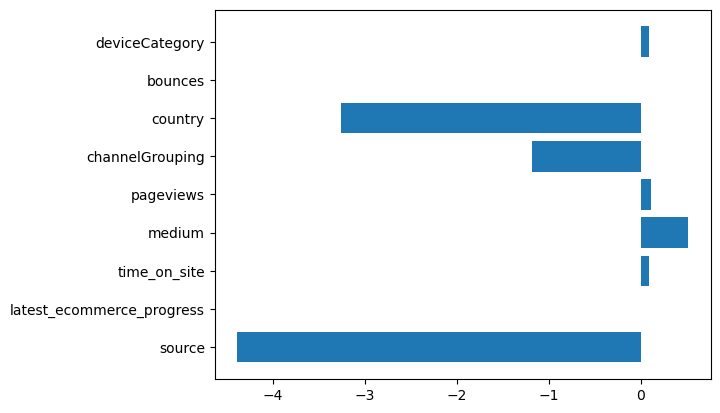

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

results = {k:v for k,v in explanations[4][0].attributions[0].feature_attributions.items()}
names = list(results.keys())
values = []
for i in results.values():
    values.append(i.pop())
    
plt.barh(range(len(results)), values, tick_label=names)

## Cleaning

In [ ]:
!rm -f source.tar source.tar.gz
!rm -fr source